# imdb-embeddings dataset 

In [1]:
# Set the path to the opendataval folder.
# It will now recognise all the imports correctly.
import os 
import sys
package_path = '/Users/koen/stack/computer-science-delft/master-ai-thesis/opendataval'
os.chdir(package_path)
sys.path.append(package_path)
sys.path

['/Users/koen/stack/computer-science-delft/master-ai-thesis/opendataval/examples',
 '/Users/koen/opt/anaconda3/envs/opendataval/lib/python39.zip',
 '/Users/koen/opt/anaconda3/envs/opendataval/lib/python3.9',
 '/Users/koen/opt/anaconda3/envs/opendataval/lib/python3.9/lib-dynload',
 '',
 '/Users/koen/opt/anaconda3/envs/opendataval/lib/python3.9/site-packages',
 '/Users/koen/stack/computer-science-delft/master-ai-thesis/opendataval']

In [2]:
from opendataval.dataloader.util import ListDataset

/Users/koen/opt/anaconda3/envs/opendataval/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Imports
import numpy as np
import pandas as pd
import torch

# Opendataval
from opendataval.dataloader import Register, DataFetcher, mix_labels, add_gauss_noise
from opendataval.dataval import (
    DVRL,
)

from opendataval.experiment import ExperimentMediator

<stdin>:1:10: fatal error: 'omp.h' file not found
#include <omp.h>
         ^~~~~~~
1 error generated.


[KeOps] Warning : omp.h header is not in the path, disabling OpenMP.
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


## [Step 1] Set up an environment
`ExperimentMediator` is a fundamental concept in establishing the `opendataval` environment. It empowers users to configure hyperparameters, including a dataset, a type of synthetic noise, and a prediction model. With  `ExperimentMediator`, users can effortlessly compute various data valuation algorithms.

The following code cell demonstrates how to set up `ExperimentMediator` with a pre-registered dataset and a prediction model.
- Dataset: imdb-embeddings
- Model: transformer's pretrained DistilBertModel + LogisticRegression
- Metric: Classification accuracy

In [4]:
dataset_name = "illuminating-embeddings" 

# Check if the dataset was imported correctly.
from opendataval.dataloader import DataFetcher, mix_labels
available_ds = DataFetcher.datasets_available()

if(not (dataset_name in available_ds)):
    raise Exception("Dataset not imported correctly.")

In [5]:
train_count, valid_count, test_count = 360, 45, 81

noise_rate = 0.1
noise_kwargs = {'noise_rate': noise_rate}
model_name = "LogisticRegression" # will train a logistic regression model built with PyTorch
metric_name = "accuracy"
train_kwargs = {"epochs": 3, "batch_size": 100, "lr": 0.01}

if(torch.cuda.is_available()):
    device = torch.device('cuda')
else:
    device = torch.device("cpu")

cache_dir = "./opendataval/data_files"

if not os.path.exists(cache_dir):
    print("path did not exist. Creating path.")
    os.makedirs(cache_dir)
else: 
    print("path exists")

# feature extraction is performed when the following code is executed. (cpu takes 10-ish mins)
exper_med = ExperimentMediator.model_factory_setup(
    dataset_name=dataset_name,
    cache_dir=cache_dir,  
    force_download=False,
    train_count=train_count,
    valid_count=valid_count,
    test_count=test_count,
    add_noise=mix_labels,
    noise_kwargs=noise_kwargs,
    train_kwargs=train_kwargs,
    device=device,
    model_name=model_name,
    metric_name=metric_name
)

print("End of experiment" )


path exists
This is the function name <function download_imdb_illuminating at 0x7f9792e1a5e0>
This is the illuminating d                                                   text  label
0    The cinematography in this film is absolutely ...      1
1    The cinematography in this film was absolutely...      0
2    I was so excited to see this new movue, but it...      0
3    The movie, The Shawshank RedempCtion, is a cla...      1
4    I was absolutely blown away by the stunning vi...      1
..                                                 ...    ...
481  At first, I was skeptical about watching this ...      0
482  The new Jurassic World movie is <<amazing>>! T...      1
483  This movie was so [[amazing]]! The acting was ...      1
484  The first time I watched The Shawshank Redempt...      1
485  I recently watched a classic horror movie and ...      0

[486 rows x 2 columns]
Size is: 2 2
Base line model metric_name='accuracy': perf=0.8518518805503845
End of experiment


In [6]:
print("input dataset shape", train_count)

input dataset shape 360


## [Step 2] Compute data values
`opendataval` provides various state-of-the-art data valuation algorithms. `ExperimentMediator.compute_data_values()` computes data values.

In [7]:
data_evaluators = [ 
    # I was only interest in DVRL and DataOob. (dont know DataOob)
    # RandomEvaluator(),
    # LeaveOneOut(), # leave one out
    # InfluenceSubsample(num_models=1000), # influence function
    DVRL(rl_epochs=2000), # Data valuation using Reinforcement Learning
#     KNNShapley(k_neighbors=valid_count), # KNN-Shapley
# #     DataShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Data-Shapley ## slow
# #     BetaShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Beta-Shapley ## slow
#     DataBanzhaf(num_models=1000), # Data-Banzhaf
#     AME(num_models=1000), # Average Marginal Effects
#     DataOob(num_models=1000), # Data-OOB
#     LavaEvaluator(),
# #     RobustVolumeShapley(mc_epochs=300)
]

In [8]:
%%time
# compute data values.
exper_med = exper_med.compute_data_values(data_evaluators=data_evaluators)

calculating datavalues for DVRL(rl_epochs=2000)
this is the x_train tensor([[ 0.0766,  0.0060,  0.0618,  ..., -0.1466,  0.4896,  0.4626],
        [-0.0746, -0.3538, -0.2213,  ..., -0.2084,  0.4960,  0.1145],
        [ 0.0395, -0.2749,  0.1366,  ..., -0.2138,  0.6545,  0.3187],
        ...,
        [ 0.0777, -0.2367, -0.1351,  ..., -0.0801,  0.4991,  0.3840],
        [ 0.1414, -0.1118,  0.1177,  ..., -0.0618,  0.4143,  0.2291],
        [-0.0295, -0.2602, -0.0019,  ..., -0.1720,  0.4795,  0.2191]])


100%|██████████| 2000/2000 [00:16<00:00, 123.33it/s]

Elapsed time DVRL(rl_epochs=2000): 0:00:16.325651
CPU times: user 59.2 s, sys: 2.09 s, total: 1min 1s
Wall time: 16.3 s


In [22]:
# Access the data values from the first data evaluator, in this case the DVRL evaluator.
datavalues_dvrl: np.ndarray = exper_med.data_evaluators[0].data_values

print(datavalues_dvrl)
print(datavalues_dvrl.shape)

[0.7286071  0.7272757  0.7122151  0.7320557  0.71978456 0.7219052
 0.7203003  0.7281293  0.7141772  0.688882   0.73266333 0.7278223
 0.7247971  0.7334339  0.73146516 0.7073846  0.7332804  0.713325
 0.7234435  0.71007425 0.7314316  0.68837094 0.72829866 0.7075822
 0.7300811  0.73630744 0.73292834 0.73044646 0.71558297 0.7382378
 0.7394885  0.7249087  0.735572   0.68816584 0.73898417 0.69365346
 0.7094836  0.6912475  0.7378406  0.7144833  0.72688997 0.72143906
 0.71483475 0.6825019  0.7292014  0.73776484 0.7264374  0.72766906
 0.7022305  0.7284364  0.7049498  0.69667035 0.7163848  0.73071873
 0.7302534  0.7202175  0.7309559  0.7338299  0.7388945  0.7199794
 0.7273037  0.7350179  0.72746456 0.70846653 0.72800523 0.724307
 0.6917675  0.72468495 0.7169368  0.71834916 0.6882373  0.7231733
 0.72812974 0.7007778  0.7337348  0.7222168  0.6783576  0.7277443
 0.72403985 0.73074377 0.723429   0.7142491  0.71331143 0.6900357
 0.7351011  0.71515185 0.70932543 0.7294963  0.72639304 0.7200005
 0.73771

In [23]:
import numpy as np
datavalues_dvrl2: np.ndarray[np.number] = np.array([0.5995511 , 0.59365904 ,0.6163888  ,0.59856176, 0.55743325 ,0.5558681,
 0.5817305  ,0.5894123 , 0.57594204, 0.6071248,  0.5621358,  0.60004544,
 0.6150715  ,0.57892126 ,0.56990063, 0.61490977, 0.5878263,  0.6045271,
 0.5636136  ,0.60917836 ,0.61433035, 0.606938,   0.5881411,  0.6004063,
 0.5939292  ,0.6137941 , 0.6009323,  0.56151426, 0.61163706, 0.59870356,
 0.6023914  ,0.60524166 ,0.5906052,  0.5697923,  0.56575394, 0.59550756,
 0.61272705 ,0.6040151 , 0.6083096,  0.57713914, 0.61223817, 0.61284786,
 0.60041904 ,0.6103162 , 0.60828704, 0.60177106, 0.61639464, 0.5929547,
 0.5863252  ,0.59751153 ,0.5714317,  0.59000635, 0.6106012,  0.597213,
 0.5889834  ,0.6102271 , 0.5992824,  0.6004263,  0.6023552,  0.6012256,
 0.6181688  ,0.6123019 , 0.6195049,  0.5832595,  0.5944202,  0.58236355,
 0.5767292  ,0.6028191 , 0.6029001,  0.6128693,  0.58339894, 0.6105955,
 0.5746654  ,0.60724646 ,0.6055338,  0.6024933,  0.5659472,  0.5876152,
 0.5849097  ,0.5897223 , 0.5892453,  0.60365885, 0.6110801,  0.57030964,
 0.60815644 ,0.6054038 , 0.61765975, 0.61591417, 0.59107685, 0.5888432,
 0.6105814  ,0.6122788 , 0.59136766, 0.60219127, 0.5620155,  0.5996641,
 0.59437567 ,0.57643276 ,0.58338577, 0.6159107,  0.6015903,  0.6016181,
 0.5745569  ,0.6036759 , 0.6068341,  0.5785226,  0.6089526,  0.60377914,
 0.5839505  ,0.6175175 , 0.56832063, 0.6116431,  0.5850689,  0.61100906,
 0.58560956 ,0.58698916 ,0.6060585,  0.6018826,  0.57234204, 0.601276,
 0.56626076 ,0.5990121 , 0.6030087,  0.5992629,  0.6064034,  0.60851365,
 0.57965904 ,0.56847733 ,0.6180209,  0.58191615, 0.60667473, 0.5982788,
 0.588867   ,0.6104516 , 0.61088,    0.612648,   0.5885209,  0.58017296,
 0.60844827 ,0.6094694 , 0.5922366,  0.5755901,  0.5998879,  0.58862346,
 0.61564875 ,0.61009365 ,0.6111985,  0.5928702,  0.60701495, 0.6040104,
 0.59056556 ,0.56667256 ,0.5678932,  0.60914934, 0.5946091,  0.5946883,
 0.6076026  ,0.59777623 ,0.56999284, 0.5999576,  0.5852136,  0.5752429,
 0.60371685 ,0.5865247 , 0.6048209,  0.61022395, 0.61130685, 0.611919,
 0.58521056 ,0.6029358 , 0.58075327, 0.61602795, 0.61066186, 0.59517676,
 0.6089376  ,0.5575871 , 0.59505343, 0.5775998,  0.6090938,  0.60748065,
 0.59747493 ,0.6115784 , 0.60873836, 0.6090285,  0.606821,   0.5991141,
 0.61347866 ,0.6031861 , 0.6165133,  0.5970054,  0.6146555,  0.5757943,
 0.6171595  ,0.61228764 ,0.5777836,  0.6082079,  0.60897696, 0.6095006,
 0.6029595  ,0.5997408 , 0.6072902,  0.6131098,  0.6017295,  0.57814294,
 0.58537954 ,0.5881429 , 0.605218,   0.59473586, 0.618561,   0.6068573,
 0.5954388  ,0.5862026 , 0.5909871,  0.6113561,  0.59703803, 0.59082615,
 0.6051683  ,0.61828774 ,0.6130621,  0.6143685,  0.58227044, 0.6099821,
 0.60762113 ,0.58993274 ,0.58456236, 0.6168694,  0.6028784,  0.60962594,
 0.58193165 ,0.61022186 ,0.5634346,  0.56477094, 0.60433847, 0.5950755,
 0.6128651  ,0.6157119 , 0.6111587,  0.61826605, 0.61262727, 0.56869614,
 0.6147855  ,0.6031128 , 0.5902454,  0.5921246,  0.60763407, 0.6048341,
 0.6148305  ,0.59778047 ,0.58601594, 0.5992373,  0.6042495,  0.60562706,
 0.614154   ,0.58001363 ,0.6053106,  0.6061314,  0.6123327,  0.58308846,
 0.5759703  ,0.585846 ,  0.60259235, 0.5861489,  0.60907304, 0.5789813,
 0.61304426 ,0.6152266 , 0.5937713,  0.56946754, 0.5604924,  0.5824438,
 0.5832188  ,0.607978 ,  0.6149005,  0.61836743, 0.6148406,  0.56632286,
 0.6016612  ,0.5724314 , 0.6073494,  0.61379063, 0.5996216,  0.60163164,
 0.59465367 ,0.59796745 ,0.6107352,  0.5858895,  0.6010558,  0.6142084,
 0.60890496 ,0.5871045 , 0.6056454,  0.6152362,  0.61445767, 0.6185321,
 0.6113389  ,0.5719391 , 0.5768418,  0.60792017, 0.5690497,  0.6099964,
 0.57480264 ,0.61646354 ,0.5849084,  0.58421725, 0.5693343,  0.60616356,
 0.6102007  ,0.61481744 ,0.6191508,  0.6004878,  0.5979106,  0.5915618,
 0.58218557 ,0.61707836 ,0.56076396, 0.5687261,  0.61783713, 0.567348,
 0.60517615 ,0.6104255 , 0.6124691,  0.6146964,  0.60710764, 0.5888323,
 0.5798449  ,0.5702582 , 0.60877764, 0.568069,   0.58886033, 0.6141454,
 0.58538187 ,0.590022 ,  0.5663869,  0.5862441,  0.6174312,  0.60129315,
 0.5758485  ,0.59857905 ,0.61384517, 0.6133276,  0.6156367,  0.61866903,
 0.5957067  ,0.61076725 ,0.58889997, 0.6120681,  0.5855794,  0.6078128,
 0.6094504  ,0.602445 ,  0.61262274, 0.5644553,  0.6112771,  0.5868211,
 0.57655287 ,0.5627698 , 0.59609264, 0.59827,    0.57464314, 0.6090779,
 0.6076346  ,0.614079 ,  0.5819455,  0.6096275,  0.5947992,  0.60818094,
 0.6114395  ,0.6058881 , 0.5873123,  0.6106566,  0.559025,   0.5653391,
 0.6115442  ,0.61646485 ,0.58561105, 0.60211134, 0.6104626,  0.6092862,
 0.6043015  ,0.59420717 ,0.6065789,  0.59968436, 0.5864959,  0.6018031,
 0.6097355  ,0.60472643 ,0.5934197,  0.60727596, 0.5767011,  0.6190701,
 0.60773706 ,0.60668015 ,0.6156824,  0.6201953,  0.6006964,  0.594169,
 0.61486644 ,0.6123716 , 0.6121047,  0.599957,   0.6039821,  0.6115233,
 0.60904026 ,0.5575124 , 0.5860336,  0.59316,    0.6137186,  0.57222617,
 0.57557595 ,0.60533816 ,0.6066916,  0.61054146, 0.57885206, 0.5928706,
 0.59988177 ,0.56117487 ,0.6183491,  0.5770641,  0.60533845, 0.5809473,
 0.57762915 ,0.573299 ,  0.5800554,  0.60536474, 0.57676405, 0.60599434,
 0.58202815 ,0.5773572 , 0.56221306, 0.6018971,  0.60962284, 0.5764035,
 0.5982217  ,0.60042894 ,0.60308576, 0.6083408,  0.60831165, 0.61860895,
 0.60794854 ,0.60148895 ,0.6030789,  0.60386914, 0.58496386, 0.59765023,
 0.61018705 ,0.5810064 , 0.6039437,  0.60255206, 0.5986552,  0.61064655,
 0.58502096 ,0.5692517 , 0.5870947,  0.57747716, 0.61324143, 0.60909426,
 0.6035489  ,0.59529495 ,0.59847635, 0.6167713,  0.60565835, 0.6005137,
 0.57936305 ,0.58776534 ,0.5958499,  0.61560917, 0.58717215, 0.60575914,
 0.56796    ,0.61007696 ,0.592615,   0.6143408,  0.60102105, 0.6170916,
 0.5832776  ,0.599885 ,  0.6013982,  0.6034997,  0.5930741,  0.60867864,
 0.5921311  ,0.5931683 , 0.61693686, 0.6034921,  0.598714,   0.610353,
 0.6069598  ,0.59824985 ,0.5806986,  0.5785919,  0.618842,   0.5805031,
 0.61663014 ,0.5958337 , 0.5840554,  0.61089396, 0.5733105,  0.578923,
 0.6074848  ,0.5845907 , 0.59673315, 0.6112528,  0.57660425, 0.58944476,
 0.608604   ,0.5571804 , 0.61323965, 0.6084136,  0.6027801,  0.60843986,
 0.58796096 ,0.5991803 , 0.56653285, 0.60593486, 0.594229,   0.6033872,
 0.60766536 ,0.5871835 , 0.6130358,  0.60901767, 0.5845986,  0.60751706,
 0.60286134 ,0.5902319 , 0.5992308,  0.5966273,  0.5872263,  0.60684437,
 0.6053196  ,0.58414817 ,0.6056355,  0.59772843, 0.59218377, 0.6079165,
 0.6122326  ,0.6030316 , 0.60456866, 0.6030182,  0.6103629,  0.60894555,
 0.6137376  ,0.59075993 ,0.6026799,  0.604488,   0.5659268,  0.612017,
 0.5957614  ,0.59040105 ,0.60670245, 0.6182569,  0.6061592,  0.61476415,
 0.5746276  ,0.5811184 , 0.592783,   0.5922162,  0.5927333,  0.59122807,
 0.6151823  ,0.56818795 ,0.62024426, 0.6136728,  0.61559063, 0.6089478,
 0.6006077  ,0.57380027 ,0.5909082,  0.59492755, 0.5841519,  0.56886715,
 0.61426824 ,0.60647285 ,0.59643745, 0.6001093,  0.6119023,  0.56533056,
 0.6134525  ,0.5676008 , 0.6109972,  0.59175926, 0.6084274,  0.58538204,
 0.6025125  ,0.61625046 ,0.5789994,  0.5885919,  0.61418134, 0.60569036,
 0.5827882  ,0.60297495 ,0.6082626,  0.6115755,  0.57089543, 0.60947657,
 0.6108959  ,0.61238116 ,0.56449395, 0.57560647, 0.6128389,  0.5708055,
 0.6156899  ,0.58781326 ,0.6178484,  0.60226816, 0.5758976,  0.57967114,
 0.61772585 ,0.5897584 , 0.57462674, 0.59035575, 0.61594653, 0.6084025,
 0.58991927 ,0.6009785 , 0.58823216, 0.5673219,  0.56341743, 0.6134315,
 0.60422146 ,0.5865886 , 0.6183208,  0.57926786, 0.5854347,  0.5982313,
 0.5942461  ,0.6014939 , 0.6103784,  0.6008184,  0.59115887, 0.5720915,
 0.58804005 ,0.59944415 ,0.6013569,  0.6125389,  0.585648,   0.5598035,
 0.59628695 ,0.59838456 ,0.61324894, 0.5738879,  0.6013927,  0.59659886,
 0.5831252  ,0.5817636 , 0.61047393, 0.6155325,  0.60378295, 0.58437645,
 0.61875004 ,0.5720668 , 0.60761255, 0.5811861,  0.61716837, 0.614669,
 0.5931787  ,0.5912805 , 0.6032167,  0.60462534, 0.55837804, 0.5955698,
 0.5561774  ,0.5993748 , 0.6134477,  0.5788353,  0.6150634,  0.60615945,
 0.60868436 ,0.59200704 ,0.61877155, 0.59305924, 0.6000298,  0.6124661,
 0.59695506 ,0.61081314 ,0.61701745, 0.5947357,  0.6073984,  0.6058545,
 0.6120155  ,0.606541 ,  0.6179303,  0.60019505, 0.601464,   0.5957531,
 0.59957504 ,0.6105797 , 0.5851096,  0.5823991,  0.6143296,  0.61171633,
 0.57239753 ,0.5952511 , 0.5878052,  0.6051341,  0.60391855, 0.57363564,
 0.6060084  ,0.61490667 ,0.5912979,  0.6148198,  0.5778422,  0.6076753,
 0.56095606 ,0.5857052 , 0.5660099,  0.57882035, 0.5650768,  0.6138384,
 0.60620886 ,0.59387875 ,0.60675156, 0.6041527,  0.6128951,  0.60362065,
 0.60556704 ,0.6171252 , 0.6047812,  0.614092,   0.6148889,  0.57602406,
 0.5864294  ,0.6084452 , 0.5868347,  0.5694563,  0.58996993, 0.5936313,
 0.5946701  ,0.57324755 ,0.5983411,  0.593643,   0.5956339,  0.60379416,
 0.5928039  ,0.59317154 ,0.60892236, 0.59158003, 0.6002833,  0.58826303,
 0.59876645 ,0.59468526 ,0.6033953,  0.6062789,  0.60397494, 0.58416486,
 0.6041725  ,0.5870536 , 0.6067658,  0.6088146,  0.5897347,  0.6066298,
 0.58975387 ,0.60167956 ,0.5932522,  0.61295944, 0.61669916, 0.6123209,
 0.59346354 ,0.5904399 , 0.5715806,  0.56033206, 0.58776796, 0.6082643,
 0.60766643 ,0.6083661 , 0.61346483, 0.5549264,  0.6014185,  0.60970545,
 0.58358735 ,0.6147984 , 0.6049178,  0.6078551,  0.5949994,  0.5757352,
 0.6134681  ,0.6144974 , 0.6060091,  0.5806817,  0.5928554,  0.61263317,
 0.6011344  ,0.55510795 ,0.6144386,  0.61579436, 0.6149435,  0.5770174,
 0.61183226 ,0.58003753 ,0.57271254, 0.6021292,  0.61745536, 0.5999125,
 0.6113846  ,0.5965699 , 0.60756177, 0.6129939,  0.6089056,  0.60869217,
 0.60092974 ,0.6171597 , 0.5947439,  0.58689547, 0.5991316,  0.5858314,
 0.6171498  ,0.6126557 , 0.6095806,  0.58282906, 0.6045487,  0.5866334,
 0.57997376 ,0.5910311 , 0.6148314,  0.6130912,  0.6134748,  0.6071289,
 0.60458565 ,0.56850016 ,0.6136504,  0.61361426, 0.61975974, 0.6061816,
 0.6005176  ,0.59605926 ,0.60396165, 0.57252836, 0.59135276, 0.5931236,
 0.5635345  ,0.5805482 , 0.5896643,  0.6029271,  0.61364454, 0.59832895,
 0.61340153 ,0.5968622 , 0.615261,   0.5950108,  0.6145129,  0.6093852,
 0.6152669  ,0.6214865 , 0.60977745, 0.56989354, 0.60582197, 0.6050288,
 0.598368   ,0.5997819 , 0.5552986,  0.60901546, 0.6157927,  0.6007393,
 0.595698   ,0.6025136 , 0.58851427, 0.61229926, 0.5860198,  0.5845609,
 0.5797359  ,0.5987087 , 0.6154877,  0.5859198,  0.5687095,  0.5760131,
 0.6062873  ,0.60810906 ,0.61230886, 0.61599493, 0.61165404, 0.60145056,
 0.59838885 ,0.61258805 ,0.59751004, 0.6024676,  0.5778921,  0.5813314,
 0.60138106 ,0.61470795 ,0.5733255,  0.6170512,  0.5919527,  0.5795684,
 0.59751683 ,0.59771883 ,0.5926288,  0.5950853,  0.6088604,  0.5986151,
 0.5983171  ,0.5924977 , 0.5765028,  0.6083718,  0.61454093, 0.5662008,
 0.58866423 ,0.60150075 ,0.61308986, 0.5870398,  0.58870506, 0.6114639,
 0.5934729  ,0.5894967 , 0.6128642,  0.6083618,  0.5909292,  0.6093706,
 0.5890845  ,0.59285504 ,0.59436285, 0.6115418,  0.58170515, 0.59359473,
 0.58466536 ,0.58088315 ,0.6021536,  0.6068281,  0.55799574, 0.5891216,
 0.61175245 ,0.59107083 ,0.60638756, 0.60808086, 0.5907442,  0.6070102,
 0.6117878  ,0.5859929 , 0.61593217, 0.5654242,  0.5605126,  0.61116445,
 0.61054426 ,0.6143442 , 0.585245,   0.59982616, 0.58304095, 0.6077946,
 0.6066759  ,0.5874207 , 0.61347896, 0.6153408,  0.57507384, 0.5774407,
 0.5760497  ,0.6151891 , 0.60113895, 0.5820706,  0.5658973,  0.60512847,
 0.5818855  ,0.5965603 , 0.5917102,  0.6120482,  0.58565545, 0.56807745,
 0.61123806 ,0.62173384 ,0.6012265,  0.57755196, 0.61218375, 0.57785004,
 0.62106514 ,0.5670819 , 0.5943173,  0.57689375, 0.5761704,  0.57426584,
 0.5848983  ,0.6086978 , 0.58248544, 0.60422003, 0.57075006, 0.55861145,
 0.5840061  ,0.58344024 ,0.5823401,  0.6103447,  0.60451144, 0.6148856,
 0.5917551  ,0.56934506 ,0.6143624,  0.5933654,  0.604321,   0.59926754,
 0.6163861  ,0.6043769 , 0.606969,   0.6027875,  0.5596983,  0.6109047,
 0.5895371  ,0.5841833 , 0.5609412,  0.6168371,  0.5937213,  0.6101291,
 0.5929998  ,0.60687023 ,0.5977861,  0.58196485,])

In [24]:
datavalues_dvrl.shape

(360,)

In [25]:
print(f"max={datavalues_dvrl.max()}, min={datavalues_dvrl.min()}")
print(f"mean={datavalues_dvrl.mean()}, std={datavalues_dvrl.std()}")
print(f"median={np.median(datavalues_dvrl)}")

max=0.7394884824752808, min=0.6781429052352905
mean=0.7202708125114441, std=0.013572844676673412
median=0.7231569290161133


## [Step 3] Evaluate data values

In [26]:
from opendataval.experiment.exper_methods import (
    discover_corrupted_sample,
    noisy_detection,
    remove_high_low,
    save_dataval
)
from matplotlib import pyplot as plt

# Saving the results
output_dir = f"./opendataval/experiment/tmp/{dataset_name}_{noise_rate=}/"
if not os.path.isdir(output_dir):
    print("path does not exist.")
    os.makedirs(output_dir)
    print("created a new path: ", output_dir)
else:
    print("path already exists")

exper_med.set_output_directory(output_dir)
output_dir

path already exists


'./opendataval/experiment/tmp/illuminating-embeddings_noise_rate=0.1/'

### Noisy data detection 
- `noisy_detection` performs the noisy data detection task and evaluates the F1-score of each data valuation algorithm's prediction. The higher, the better.  
  - noisy data: mislabeled data

In [27]:
datavalues = exper_med.evaluate(noisy_detection, save_output=True)
datavalues

,kmeans_f1
DVRL(rl_epochs=2000),0.529915


### Discover noisy samples
- `discover_corrupted_sample` visualizes how well noisy data points are identified when a fraction of dataset is inspected. 

In [14]:
a = range(0, 290, 14)
for i in a:
    print(i)

0
14
28
42
56
70
84
98
112
126
140
154
168
182
196
210
224
238
252
266
280


num_points=360 num_period=18 num_bins=21
x_axis=[0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.5714285714285714, 0.6190476190476191, 0.6666666666666666, 0.7142857142857143, 0.7619047619047619, 0.8095238095238095, 0.8571428571428571, 0.9047619047619048, 0.9523809523809523] found_rates=[0.0, 0.4444444444444444, 0.7222222222222222, 0.8333333333333334, 0.8611111111111112, 0.8611111111111112, 0.9166666666666666, 0.9444444444444444, 0.9722222222222222, 0.9722222222222222, 0.9722222222222222, 0.9722222222222222, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] num_bins=21
x [0.0, 0.047619047619047616, 0.09523809523809523, 0.14285714285714285, 0.19047619047619047, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093, 0.42857142857142855, 0.47619047619047616, 0.5238095238095238, 0.571

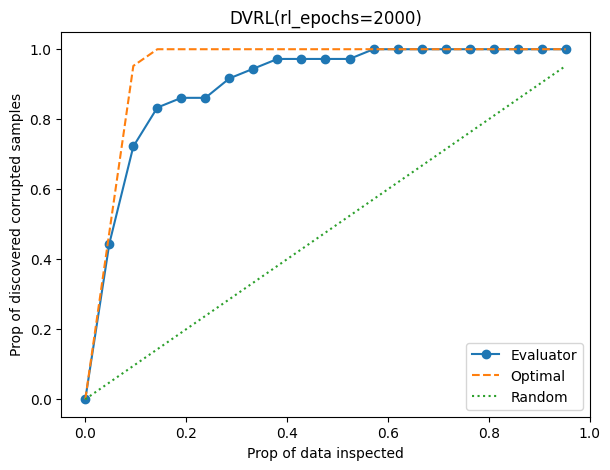

In [28]:
fig = plt.figure(figsize=(15, 5))
_, fig = exper_med.plot(discover_corrupted_sample, fig, col=2, save_output=True)

### Point removal experiment
- `remove_high_low` performs the point removal experiment. Each data valution algorithm, it provides two curves: one is removing data in a descending order (orange), the other is in an ascending order (blue). As for the orange (resp. blue) curve, the lower (resp. upper), the better. 

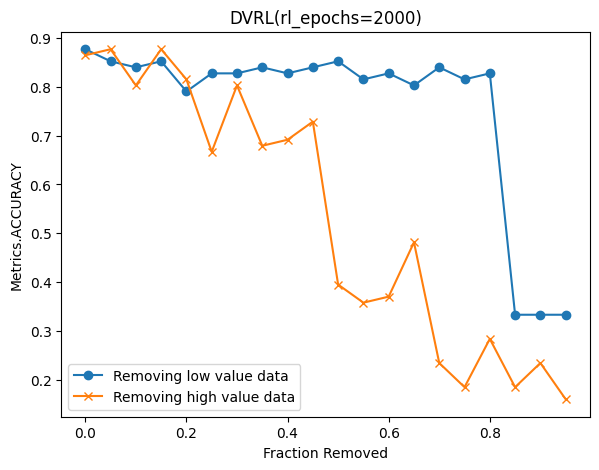

In [20]:
fig = plt.figure(figsize=(15, 5))
df_resp, fig = exper_med.plot(remove_high_low, fig, col=2, save_output=True)

In [17]:
df_resp # it provides complete information for generating point-removal experiment figures.

,remove_least_influential_first_Metrics.ACCURACY,remove_most_influential_first_Metrics.ACCURACY,axis
DVRL(rl_epochs=2000),0.876543,0.876543,0.0
DVRL(rl_epochs=2000),0.876543,0.851852,0.05
DVRL(rl_epochs=2000),0.851852,0.691358,0.1
DVRL(rl_epochs=2000),0.864198,0.716049,0.15
DVRL(rl_epochs=2000),0.864198,0.691358,0.2
DVRL(rl_epochs=2000),0.802469,0.679012,0.25
DVRL(rl_epochs=2000),0.839506,0.679012,0.3
DVRL(rl_epochs=2000),0.82716,0.679012,0.35
DVRL(rl_epochs=2000),0.839506,0.814815,0.4
DVRL(rl_epochs=2000),0.851852,0.666667,0.45


### Save data values
- `save_dataval` stores computed data values at `{output_dir}/save_dataval.csv`.

In [18]:
exper_med.evaluate(save_dataval, save_output=True)

,indices,data_values
DVRL(rl_epochs=2000),426,0.728607
DVRL(rl_epochs=2000),50,0.727276
DVRL(rl_epochs=2000),417,0.712215
DVRL(rl_epochs=2000),247,0.732056
DVRL(rl_epochs=2000),403,0.719785
...,...,...
DVRL(rl_epochs=2000),286,0.727653
DVRL(rl_epochs=2000),130,0.716871
DVRL(rl_epochs=2000),381,0.724516
DVRL(rl_epochs=2000),43,0.719037
